# Defining a dataset
I am using this one https://www.kaggle.com/competitions/it1244-brain-tumor-dataset

In [1]:
import FileIO
include("./data.jl")
include("./transforms.jl")

# create the dataset from all files in a folder, label function gets the last folder in path
ds = DatasetLabeled()

DatasetLabeled(Sample[], Any[])

`data.csv` looks like
```csv
76,benign
77,benign
155,malignant
156,malignant
...
```

In [2]:
path = "D:/datasets/it1244-brain-tumor-dataset/data"

# define the loader
# it reads the file, resizes to 256,256, converts to flux-compatible array and ensures 3 channels
# I had to add `ToChannels(3)` to my loader since most images in the dataset have 3 channels, but a few have 1.
loader = Compose(FileIO.load, Resize(256, 256), to_image_arr, ToChannels(3))

# add all samples
open("$path/train/data.csv") do f
    while !eof(f)
        num, label = split(replace(readline(f), "\ufeff" => ""), ",")
        add_sample!(ds, "$path/train/$num.jpg", loader=loader, label=label)
    end
end

ds.classes

2-element Vector{Any}:
 "benign"
 "malignant"

In [3]:
# show all samples
[i.sample for i in ds.samples][1:4]

4-element Vector{String}:
 "D:/datasets/it1244-brain-tumor-dataset/data/train/17.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/18.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/19.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/20.jpg"

Indexing into a dataset returns a tuple: `(WHC array, one-hot encoded label)`

In [4]:
ds[1]

(Float32[0.0 0.03529412 … 0.007843138 0.007843138; 0.019607844 0.011764706 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.050980393 0.050980393 … 0.047058824 0.047058824;;; 0.16078432 0.20392157 … 0.2 0.2; 0.19607843 0.18039216 … 0.2 0.2; … ; 0.015686275 0.015686275 … 0.023529412 0.023529412; 0.09019608 0.09019608 … 0.09803922 0.09803922;;; 0.42352942 0.4627451 … 0.35686275 0.35686275; 0.42745098 0.4117647 … 0.38431373 0.38431373; … ; 0.0 0.0 … 0.0 0.0; 0.047058824 0.047058824 … 0.03137255 0.03137255], Bool[1, 0])

In [5]:
# size of the image array
size(ds[1][1])

(256, 256, 3)

In [6]:
# one-hot encoded label vector
ds[1][2]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

We can compute the channel-wise mean and standard deviation of the entire dataset using `mean_std`. 

This function supports arbitrary number of dimensions, as long as all samples are channel-last and have the same dimensions and channels.

In [7]:
# Compute mean and std of dataset in 32-element batches for efficiency.
meanstd = mean_std(ds, 32)

([0.24588404037058353, 0.24612058699131012, 0.246446100063622], [0.23956909030675888, 0.2396404705941677, 0.2398200985044241])

Now we can add a Normalize transform to our dataset using `add_loader!`, which adds a new function to the end of the pipeline.

In [8]:
add_loader!(ds, Normalize(meanstd))
ds.samples[1].loader

Compose((FileIO.load, Resize((256, 256)), to_image_arr, ToChannels(3), Normalize([0.24588404037058353, 0.24612058699131012, 0.246446100063622], [0.23956909030675888, 0.2396404705941677, 0.2398200985044241])))

Since we don't have a lot of images, we can significantly speed up the training by preloading them all into RAM using `preload!`

In [9]:
preload!(ds)
ds[1]

(Float32[-1.0263597 -0.87903625 … -0.9936211 -0.9936211; -0.94451326 -0.9772519 … -1.0263597 -1.0263597; … ; -1.0263597 -1.0263597 … -1.0263597 -1.0263597; -0.81355923 -0.81355923 … -0.82992846 -0.82992846;;; -0.35610124 -0.17609303 … -0.19245741 -0.19245741; -0.20882179 -0.27427933 … -0.19245741 -0.19245741; … ; -0.96158344 -0.96158344 … -0.9288547 -0.9288547; -0.6506601 -0.6506601 … -0.61793137 -0.61793137;;; 0.73840064 0.90192187 … 0.4604145 0.4604145; 0.75475276 0.6893443 … 0.5748794 0.5748794; … ; -1.027629 -1.027629 … -1.027629 -1.027629; -0.83140355 -0.83140355 … -0.8968121 -0.8968121], Bool[1, 0])

Lets also split into train and test datasets ("test" folder in the dataset is actually a folder with unlabeled samples for submission, so we need to split the "train" folder dataset)

In [10]:
ds_train, ds_test = split_dataset(ds, 0.8)

1, 392
393, 98


2-element Vector{Any}:
 DatasetLabeled(Sample[Sample(Float32[-1.0263597 -0.87903625 … -0.9936211 -0.9936211; -0.94451326 -0.9772519 … -1.0263597 -1.0263597; … ; -1.0263597 -1.0263597 … -1.0263597 -1.0263597; -0.81355923 -0.81355923 … -0.82992846 -0.82992846;;; -0.35610124 -0.17609303 … -0.19245741 -0.19245741; -0.20882179 -0.27427933 … -0.19245741 -0.19245741; … ; -0.96158344 -0.96158344 … -0.9288547 -0.9288547; -0.6506601 -0.6506601 … -0.61793137 -0.61793137;;; 0.73840064 0.90192187 … 0.4604145 0.4604145; 0.75475276 0.6893443 … 0.5748794 0.5748794; … ; -1.027629 -1.027629 … -1.027629 -1.027629; -0.83140355 -0.83140355 … -0.8968121 -0.8968121], identity, identity, "benign"), Sample(Float32[-0.9772519 -0.9772519 … -0.96088254 -0.96088254; -0.9772519 -0.9772519 … -0.96088254 -0.96088254; … ; -0.9772519 -0.9772519 … -0.9772519 -0.9772519; -0.9772519 -0.9772519 … -0.9772519 -0.9772519;;; -0.97794783 -0.97794783 … -0.96158344 -0.96158344; -0.97794783 -0.97794783 … -0.96158344 -0.96158344; …

Now we can create a DataLoader using MLUtils. Make sure to specify `collate = true`.

In [11]:
import MLUtils
dl_train = MLUtils.DataLoader(ds_train, batchsize=16, shuffle=true, collate=true)
dl_test = MLUtils.DataLoader(ds_test, batchsize=64, shuffle=false, collate=true)

2-element DataLoader(::DatasetLabeled, batchsize=64, collate=Val{true}())
  with first element:
  (256×256×3×64 Array{Float32, 4}, 2×64 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

Thats it! Time to use flux, so I defined simple CNN model (and did zero optimal architecture search for this as its a demo).

In [12]:
using Flux, CUDA, Statistics, ProgressMeter
model = Chain(
    Conv((5, 5), 3 => 16, relu), # 254?
    MaxPool((3, 3)), # 84?
    Conv((3, 3), 16 => 32, relu), # 82?
    MaxPool((2, 2)), # 41?
    Conv((3, 3), 32 => 48, relu), #39?
    MaxPool((2, 2)), # 19?
    Conv((3, 3), 48 => 64, relu), #17?
    MaxPool((2, 2)), # 8?
    Conv((3, 3), 64 => 32, relu), # 6?
    Flux.flatten,
    Dense(32 * 6 * 6, length(ds.classes)),
) |> gpu

# pass one batch through it
batch = first(dl_train)
out1 = model(batch[1] |> gpu) |> cpu

2×16 Matrix{Float32}:
 0.41852   0.715741  0.283977  0.222968  …  0.39488   0.241475  0.450193
 0.452222  0.635777  0.24088   0.20098      0.372382  0.142108  0.551063

And the training loop is copy-pasted from Flux docs, but I added testing on dl_test and accuracy

In [13]:
# Standard training loop works with our dataset out of the box
losses = []
accuracy = []
test_accuracy = []
optim = Flux.setup(Flux.Adam(1e-3), model)
@showprogress for epoch in 1:10

    # train
    for (images, labels) in dl_train
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(images |> gpu)
            # Calculate accuracy
            Flux.ignore_derivatives() do
                push!(accuracy, mean(argmax(y_hat |> cpu, dims=1) .== argmax(labels, dims=1)))
            end
            Flux.logitcrossentropy(y_hat, labels |> gpu)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)
    end

    #test
    test_accuracy_epoch = []
    for (images, labels) in dl_test
        y_hat = model(images |> gpu)
        push!(test_accuracy_epoch, mean(argmax(y_hat |> cpu, dims=1) .== argmax(labels, dims=1)))
    end
    push!(test_accuracy, mean(test_accuracy_epoch))

end

# pass one batch through the trained model
out1 = model(batch[1] |> gpu) |> cpu

Progress:  20%|█████████                                |  ETA: 0:13:56

Progress:  30%|█████████████                            |  ETA: 0:09:27

Progress:  40%|█████████████████                        |  ETA: 0:06:54

Progress:  50%|█████████████████████                    |  ETA: 0:05:04

Progress:  60%|█████████████████████████                |  ETA: 0:03:51

Progress:  70%|█████████████████████████████            |  ETA: 0:02:43

Progress:  80%|█████████████████████████████████        |  ETA: 0:01:44

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:50

Progress: 100%|█████████████████████████████████████████| Time: 0:08:11

2×16 Matrix{Float32}:
 -1.14524   5.20579  -5.46026  -1.91035  …   6.08     -3.31814  -0.641269
  4.17314  -1.07817   7.33096   3.5301      -2.37016   5.33816   6.85102

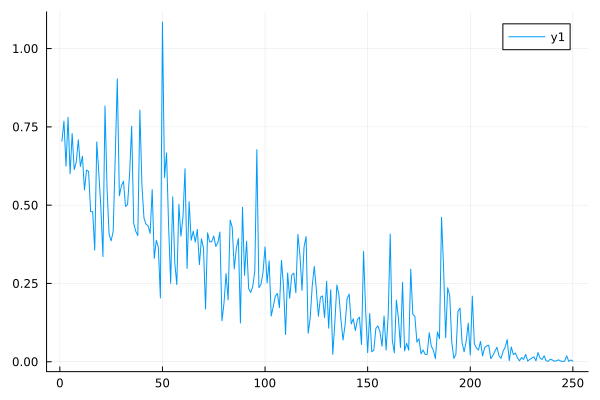

In [14]:
using Plots
plot(losses)

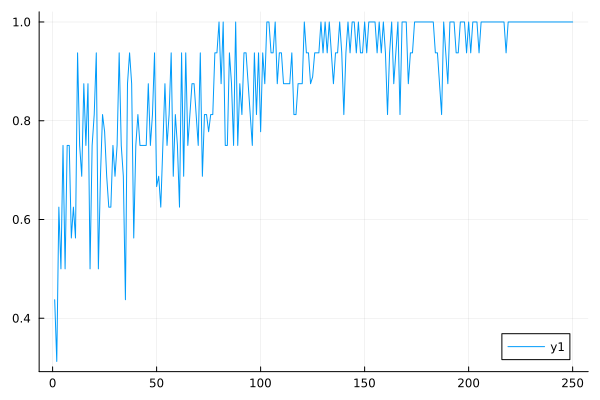

In [15]:
plot(accuracy)

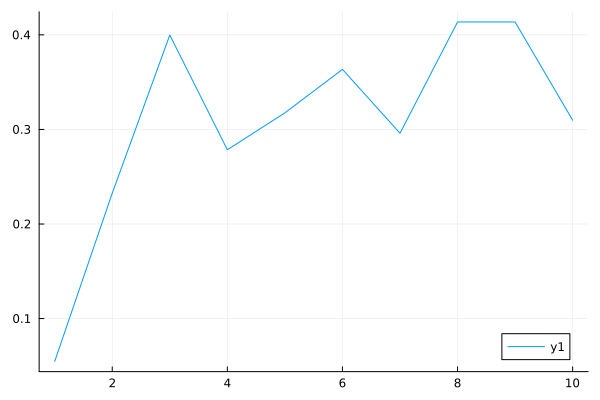

In [16]:
plot(test_accuracy)